# Oil Palm Tree Yield Analysis

Scenario:  

A team of plantation planners are concerned about the yield of oil palm trees, which seems to fluctuate. They have collected a set of data and needed help in analysing on how external factors influence fresh fruit bunch (FFB) yield. Some experts are of opinion that the flowering of oil palm tree determines the FFB yield, and are linked to the external factors. Perform the analysis, which requires some study on the background of oil palm tree physiology.

## Import Data from MS SQL Database

In [3]:
import pymssql
import pandas as pd


# server config
server = 'localhost' 
database = 'demoDB' 
username = 'sa' 
password = 'Pwd@1234'  

# open connection to MS SQL Server 
conn = pymssql.connect( server=server, 
                        user=username, 
                        password=password, 
                        database=database)  

# select all from SQL table to insert in dataframe.
query = "SELECT * FROM PalmYield"
raw_dataset = pd.read_sql(query, conn)
raw_dataset['Date'] = pd.to_datetime(raw_dataset['Date'], format='%Y-%d-%m')

## Statiscal Profile for Insight on Dataset

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(raw_dataset, title="Profiling Report for Oil Palm Yield", progress_bar=False, explorative=True)
#profile.to_file("profiling_report_for_oil_palm_yield.html")

statistical_profile = raw_dataset.describe(include='all')
statistical_profile

## Pre-Process Dataset as Needed as a Separate Copy

In [4]:
date_ = pd.to_datetime(raw_dataset['Date'])
month_ = date_.dt.month.unique()
month = date_.dt.month
year = date_.dt.year

target = raw_dataset['FFB_Yield']
dataset = raw_dataset.drop(['Date'], axis=1)

## Descriptive Analysis of PalmYield Dataset for Identifying Relationships and Trends (if any)

In [209]:
from scipy.stats import shapiro, spearmanr

rej = ""
for column in dataset:
    stat, p_val = shapiro(dataset[column].values)
    if p_val > 0.05:
        print("“"+column+"” is a normal distribution, w="+str(stat)+" p="+str(p_val))
    else:
        print("“"+column+"” is not a normal distribution, w="+str(stat)+" p="+str(p_val))

rej = ""
print("\n\n")
ptive, ntive, no = 0, 0, 0
prev = [dataset.columns[0]]
for col_ in dataset:
    for col in dataset:
        r, p = spearmanr(dataset[col_].values, dataset[col].values)
        if r > 0:
            relationship = "positive"
        else:
            relationship = "negative"
        if abs(r) >= 0.7:
            strength = "very strong"
        elif abs(r) >= 0.4 and abs(r) < 0.7:
            strength = "strong"
        elif abs(r) >= 0.3 and abs(r) < 0.4:
            strength = "moderate"
        elif abs(r) >= 0.2 and abs(r) < 0.3:
            strength = "weak"
        else:
            strength = ""
            relationship = "negligible or none"
        if p > 0.05:
            rej = "uncorrelated, fail to reject H0"
        else:
            rej = "correlated"
        if col != col_ and col not in prev:
            print("“"+col_+"” and "+"“"+col+"”: "+strength+" "+relationship+" "+rej+" (w="+str(r)+" p="+str(p)+")")
            if relationship == "negligible or none":
                no += 1
            elif relationship == "positive":
                ptive += 1
            elif relationship == "negative":
                ntive += 1
            else:
                pass
    prev.append(col_)

print("\n\npositive correlation: "+str(ptive))
print("negative correlation: "+str(ntive))
print("no correlation: "+str(no))

“SoilMoisture” is a normal distribution, w=0.9820555448532104 p=0.08353912830352783
“Average_Temp” is a normal distribution, w=0.9841978549957275 p=0.13662675023078918
“Min_Temp” is not a normal distribution, w=0.9324337840080261 p=6.3626785049564205e-06
“Max_Temp” is a normal distribution, w=0.9859548211097717 p=0.20315690338611603
“Precipitation” is not a normal distribution, w=0.9784587621688843 p=0.03651024028658867
“Working_days” is not a normal distribution, w=0.9121495485305786 p=3.6078785115023493e-07
“HA_Harvested” is a normal distribution, w=0.9857127070426941 p=0.1924653947353363
“FFB_Yield” is a normal distribution, w=0.9826728105545044 p=0.09630613029003143



“SoilMoisture” and “Average_Temp”: strong negative correlated (w=-0.6111582239161218 p=1.1434267651121323e-14)
“SoilMoisture” and “Min_Temp”:  negligible or none uncorrelated, fail to reject H0 (w=0.008096160055261746 p=0.9271585775619682)
“SoilMoisture” and “Max_Temp”: strong negative correlated (w=-0.46557457884275

In [260]:
from statsmodels.tsa.stattools import adfuller

for column in dataset:
    result = adfuller(dataset[column].values, autolag='AIC')
    if result[1] > 0.05:
        print("“"+column+"” possesses a unit root and is non-stationary, stat="+str(result[0])+" p="+str(result[1]))
    else:
        print("“"+column+"” is stationary, r="+str(tau)+" p="+str(p_val))

“SoilMoisture” possesses a unit root and is non-stationary, stat=-2.1515948388800035 p=0.22428012505393408
“Average_Temp” possesses a unit root and is non-stationary, stat=-2.107533772959667 p=0.24149604455902157
“Min_Temp” is stationary, r=0.07011955086915007 p=0.09630613029003143
“Max_Temp” possesses a unit root and is non-stationary, stat=-2.080429250024134 p=0.25245656150519474
“Precipitation” possesses a unit root and is non-stationary, stat=-2.0235484185567665 p=0.27634432968766753
“Working_days” possesses a unit root and is non-stationary, stat=-2.6733403966119553 p=0.07876624487484712
“HA_Harvested” possesses a unit root and is non-stationary, stat=-1.7626559594467592 p=0.39915315468803847
“FFB_Yield” is stationary, r=0.07011955086915007 p=0.09630613029003143


In [36]:
import warnings
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from greykite.common.viz.timeseries_plotting import plot_multivariate

warnings.filterwarnings("ignore")

def plot_multivariate_overlay(df):
    col_names = list(df.columns.values)
    y_min = df[col_names[2]].min()
    y_max = df[col_names[2]].max()
    ffb = df['FFB_Yield'].to_numpy()
    ffb = np.reshape(ffb, (130,1))
    df['FFB_Yield'] = MinMaxScaler(feature_range=(y_min, y_max)).fit_transform(ffb)
    print(df.head())
    
    fig = plot_multivariate(df, 'Date', 
                y_col_style_dict='plotly', 
                xlabel="Scale by month of year", 
                ylabel="Attribute Value (scaled to"+col_names[2]+")", 
                title="Interactive Multivariate Plot for All Attributes For Visualising Relationship")
    #fig = fig.update_yaxes(range=[y_min, y_max])
    fig.show()   
    return


for col in raw_dataset:
    if col not in ['Date', 'FFB_Yield']:  
        df = raw_dataset[['Date', 'FFB_Yield', col]]
        plot_multivariate_overlay(df)

        Date   FFB_Yield  SoilMoisture
0 2008-01-01  501.678151         616.4
1 2008-02-01  463.592437         568.9
2 2008-03-01  488.236134         577.6
3 2008-04-01  450.150420         581.1
4 2008-05-01  461.352101         545.4


        Date  FFB_Yield  Average_Temp
0 2008-01-01  26.710876     25.306452
1 2008-02-01  26.222028     26.165517
2 2008-03-01  26.538341     25.448387
3 2008-04-01  26.049493     26.903333
4 2008-05-01  26.193272     27.241935


        Date  FFB_Yield  Min_Temp
0 2008-01-01  20.578992      21.3
1 2008-02-01  20.050420      20.9
2 2008-03-01  20.392437      21.3
3 2008-04-01  19.863866      20.6
4 2008-05-01  20.019328      20.9


        Date  FFB_Yield  Max_Temp
0 2008-01-01  33.323529      32.2
1 2008-02-01  32.623529      35.1
2 2008-03-01  33.076471      32.9
3 2008-04-01  32.376471      34.8
4 2008-05-01  32.582353      35.0


        Date   FFB_Yield  Precipitation
0 2008-01-01  226.213445          184.4
1 2008-02-01  155.627731          140.2
2 2008-03-01  201.300840          280.4
3 2008-04-01  130.715126          173.3
4 2008-05-01  151.475630          140.6


        Date  FFB_Yield  Working_days
0 2008-01-01  23.722689            25
1 2008-02-01  22.865546            23
2 2008-03-01  23.420168            25
3 2008-04-01  22.563025            25
4 2008-05-01  22.815126            25


        Date      FFB_Yield  HA_Harvested
0 2008-01-01  773653.819812   777778.3951
1 2008-02-01  745250.636812   767988.2759
2 2008-03-01  763629.166988   783951.9231
3 2008-04-01  735225.983988   788987.0504
4 2008-05-01  743579.861341   813659.7222


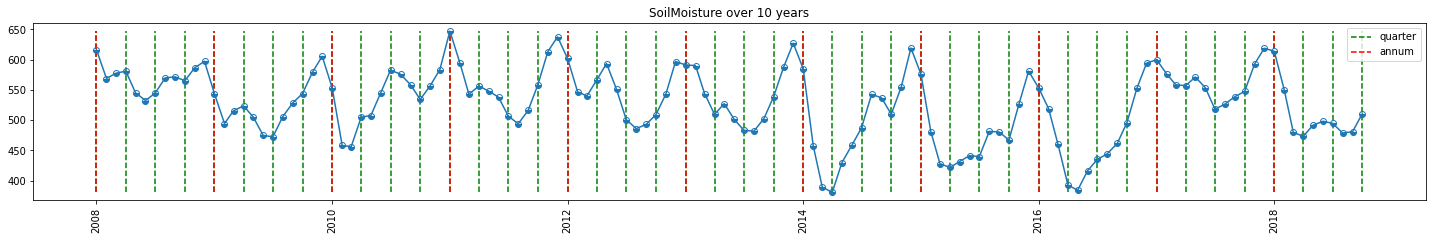

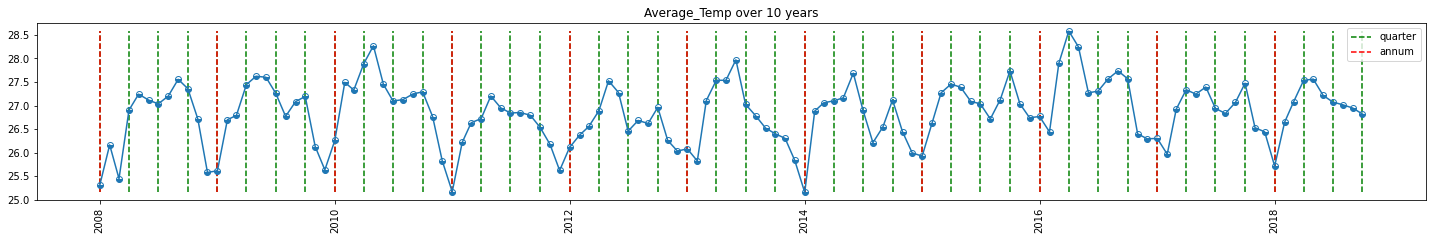

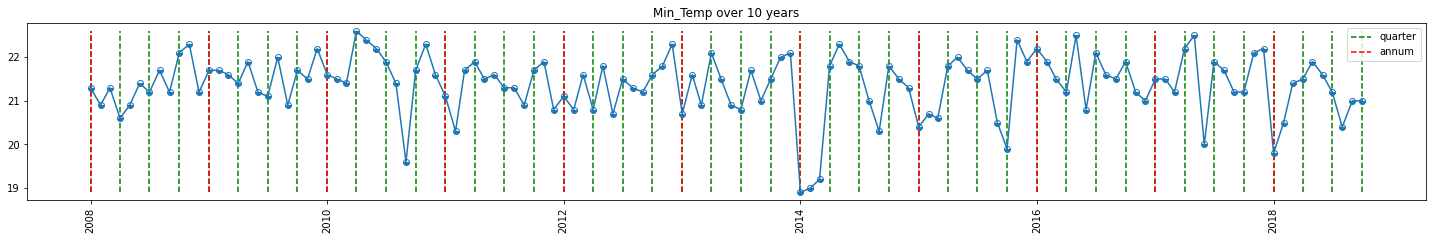

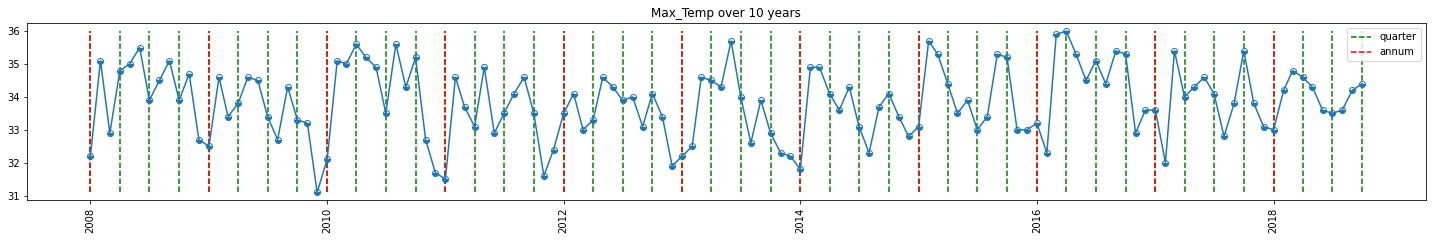

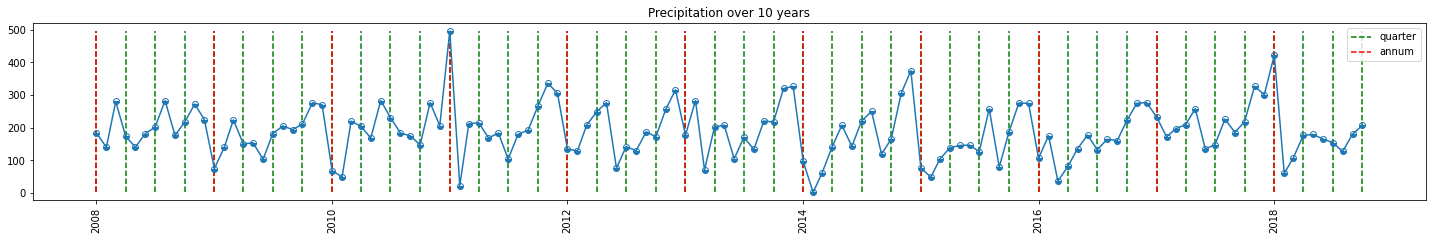

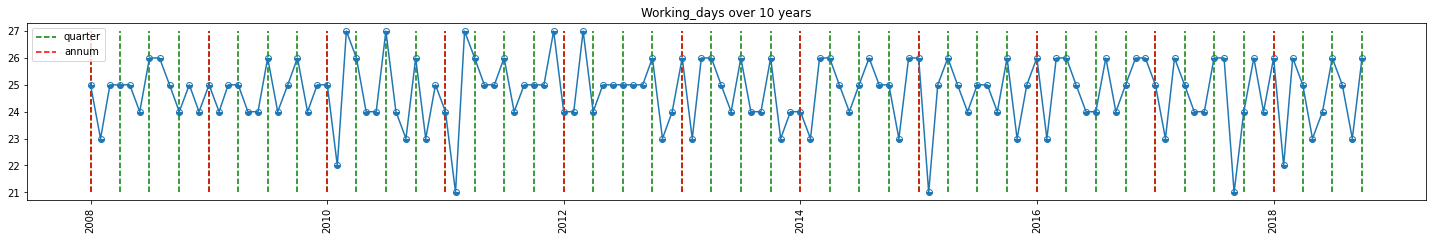

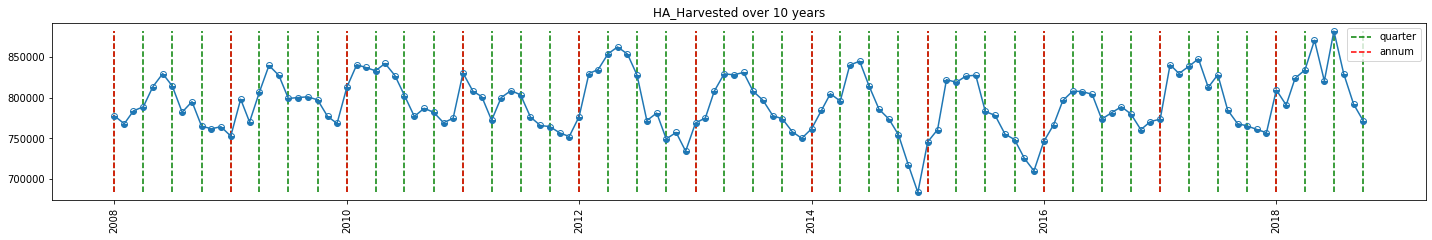

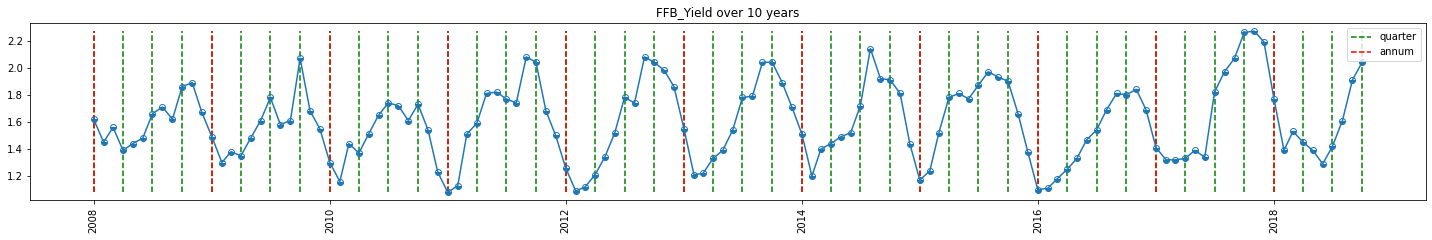

In [38]:
import matplotlib.pyplot as plt
import warnings

from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
warnings.filterwarnings("ignore")

def plot_line_trend_seasonality(df):
    col_names = list(df.columns.values)
    span = len(df['Date'])
    x_range_a = [df.iloc[i][0] for i in range(0, span, 12)]
    x_range_q = [df.iloc[i][0] for i in range(0, span, 3)]
    d_min = df[col_names[1]].min()
    d_max = df[col_names[1]].max()
    x = df[col_names[0]]
    y = df[col_names[1]]

    plt.figure(figsize=(20, 3))
    plt.plot_date(x, y, linestyle='-', fillstyle='bottom')
    plt.tight_layout()
    plt.tick_params(axis='x', rotation=90)
    plt.title(col_names[1]+" over 10 years")
    plt.vlines(x=x_range_q, colors='green', linestyle='--', label='quarter', ymin=d_min, ymax=d_max)
    plt.vlines(x=x_range_a, colors='red', linestyle='--', label='annum', ymin=d_min, ymax=d_max)
    plt.legend()
    plt.savefig("line_plot_"+col_names[1]+"_over_10_years.png")
    plt.show()
    
    '''
    # would love to just use greykite plotly but setting markers is a pain
    fig1 = ts.plot()
    #fig1.add_vline(x=x_range_a, line_width=3, line_dash="dash", line_color="green")
    #fig1.add_vline(x=x_range_q, line_width=3, line_dash="dash", line_color="red")
    fig1.show()
    '''

    ts = UnivariateTimeSeries()
    ts_dt = ts.load_data(df=df,
                        time_col=col_names[0],
                        value_col=col_names[1],
                        freq='MS')
    
    fig = ts.plot_quantiles_and_overlays(groupby_time_feature="month",
                                        show_mean=True,
                                        show_quantiles=True,
                                        show_overlays=True,
                                        overlay_label_time_feature="year",
                                        overlay_style={"line": {"width": 1}, "opacity": 0.5},
                                        center_values=False,
                                        xlabel="Month of Year",
                                        ylabel=ts.original_value_col,
                                        title="Yearly Seasonality (centered)",)
    fig.show()
    
    return

for col in dataset:
    df = raw_dataset[['Date', col]]
    plot_line_trend_seasonality(df)


<Figure size 1080x432 with 0 Axes>

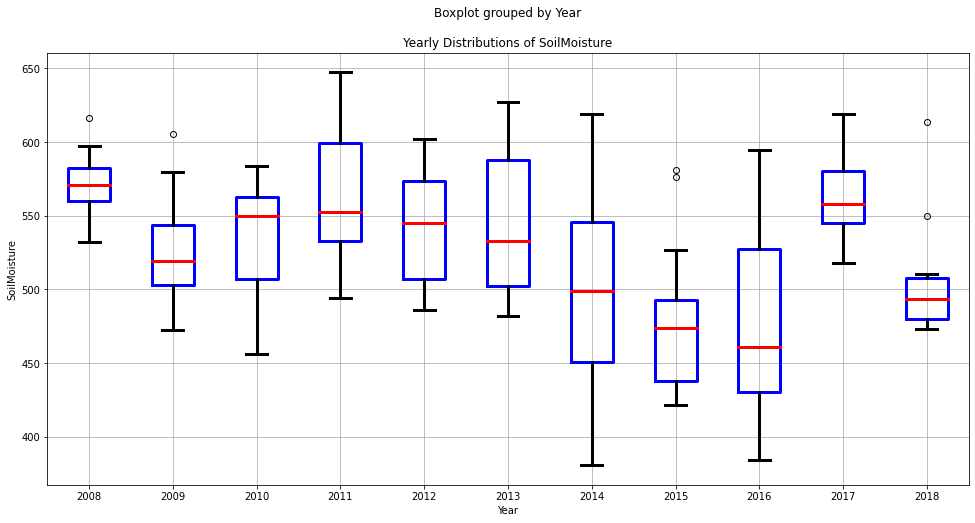

<Figure size 1080x432 with 0 Axes>

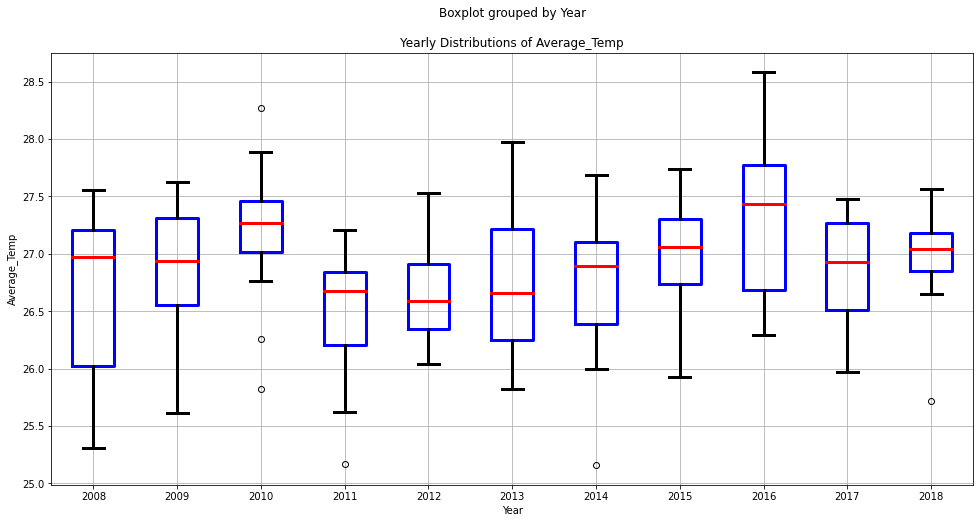

<Figure size 1080x432 with 0 Axes>

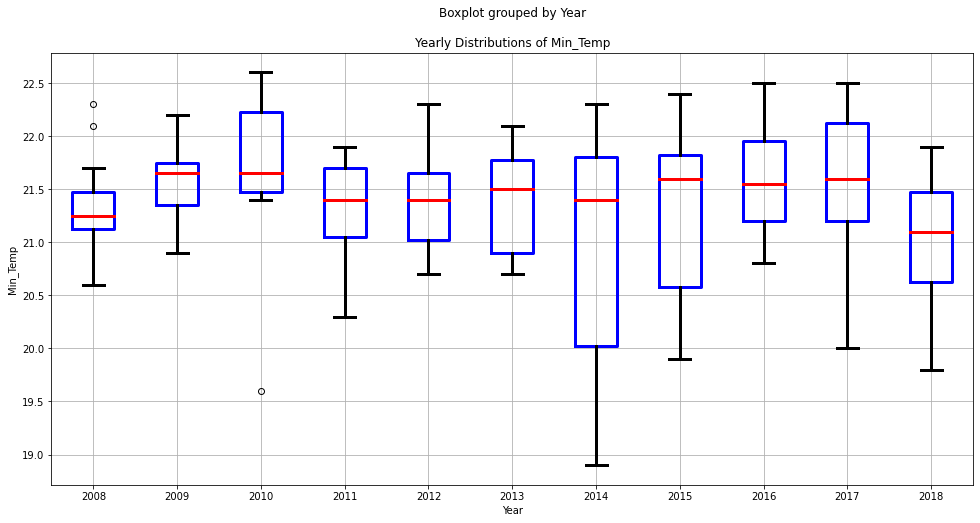

<Figure size 1080x432 with 0 Axes>

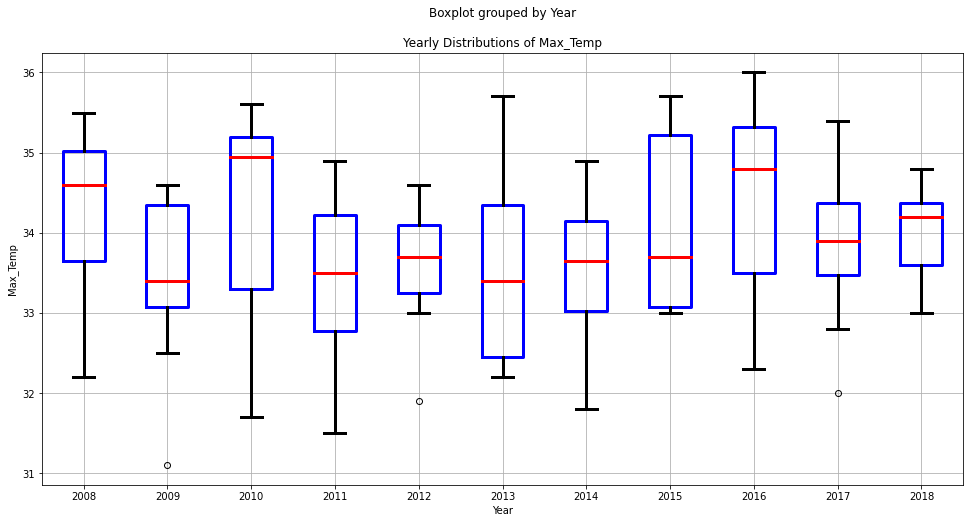

<Figure size 1080x432 with 0 Axes>

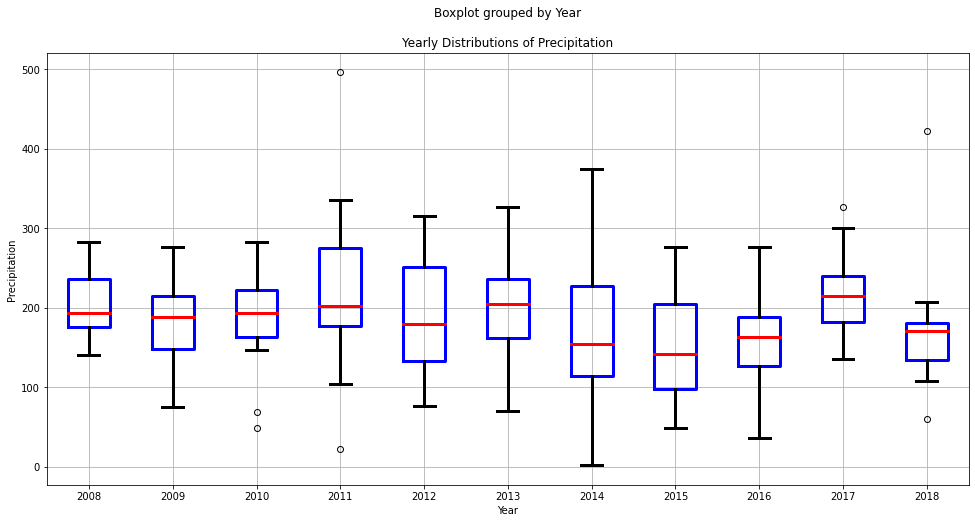

<Figure size 1080x432 with 0 Axes>

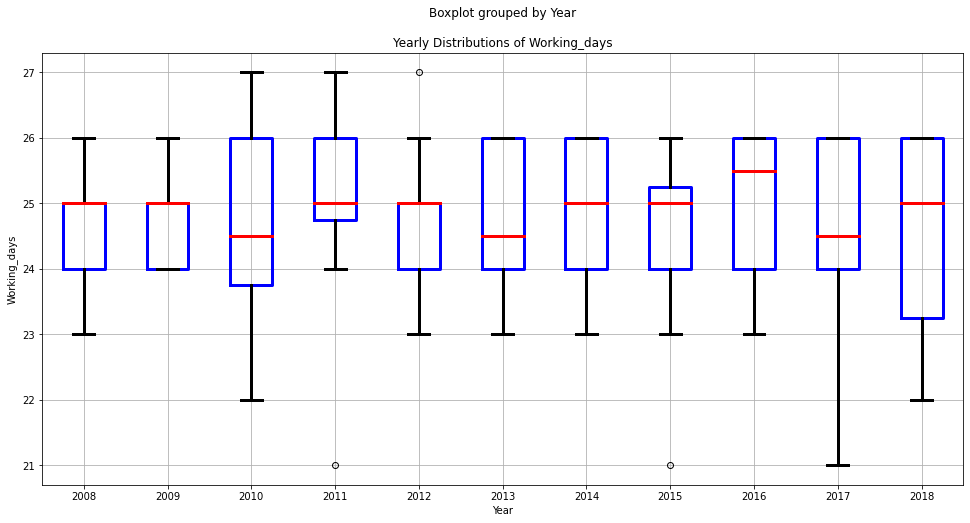

<Figure size 1080x432 with 0 Axes>

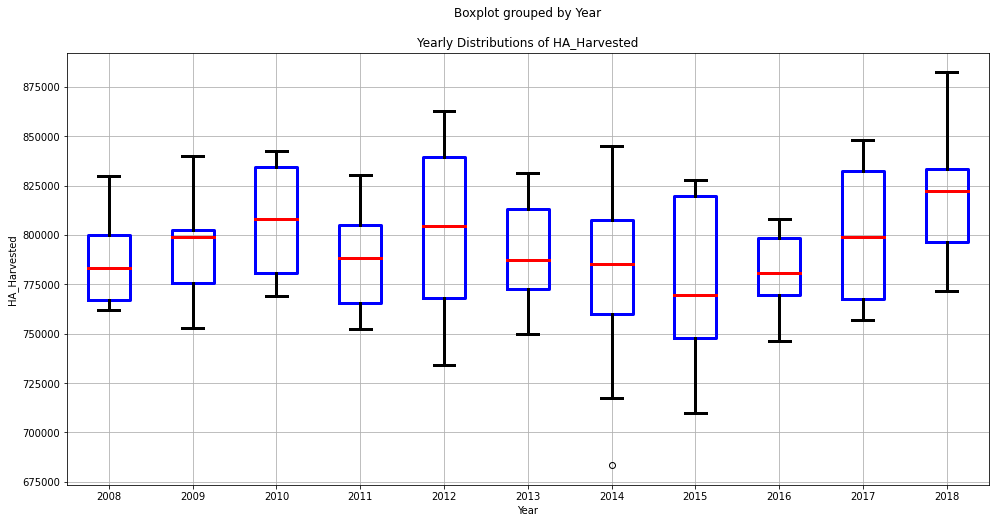

<Figure size 1080x432 with 0 Axes>

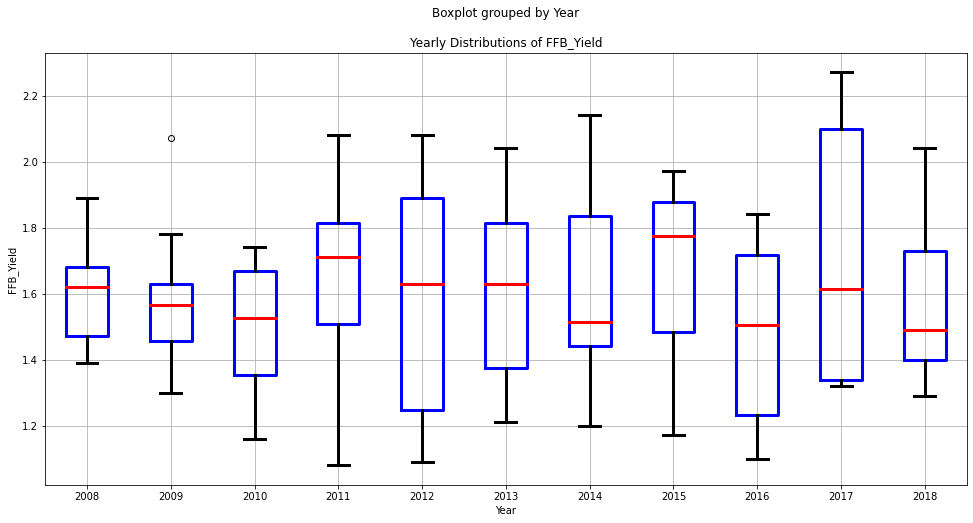

In [259]:
import numpy as np

def plot_box_plot_dist_yearly(df, start_date, end_date):
    col_names = list(df.columns.values)
    boxprops = dict(linestyle='-', linewidth=3, color='b')
    medianprops = dict(linestyle='-', linewidth=3, color='r')
    meanprops = dict(linestyle='-', linewidth=3, color='m')
    capprops = dict(linestyle='-', linewidth=3, color='k')
    whiskerprops = dict(linestyle='-', linewidth=3, color='k')

    index = pd.date_range(start=pd.to_datetime(start_date), 
                          end=pd.to_datetime(end_date), 
                          freq='MS')
    
    df['Year'] = index.year
    df = df.set_index(index, append=True).drop(['Date'], axis=1)

    plt.figure(figsize=(15,6))
    ax = df.boxplot(column=col_names[1], by='Year', figsize=(16, 8), vert=True, boxprops=boxprops,  
                    medianprops=medianprops, meanprops=meanprops,
                    capprops=capprops, whiskerprops=whiskerprops)
    ax.set( title="Yearly Distributions of "+col_names[1],
            xlabel='Year',
            ylabel=col_names[1])
    plt.savefig("distribution_yearly_"+col_names[1]+".png")
    plt.show()    
    return

for col in dataset:
    df = raw_dataset[['Date', col]]
    plot_box_plot_dist_yearly(df, '2008-01-01', '2018-10-01')

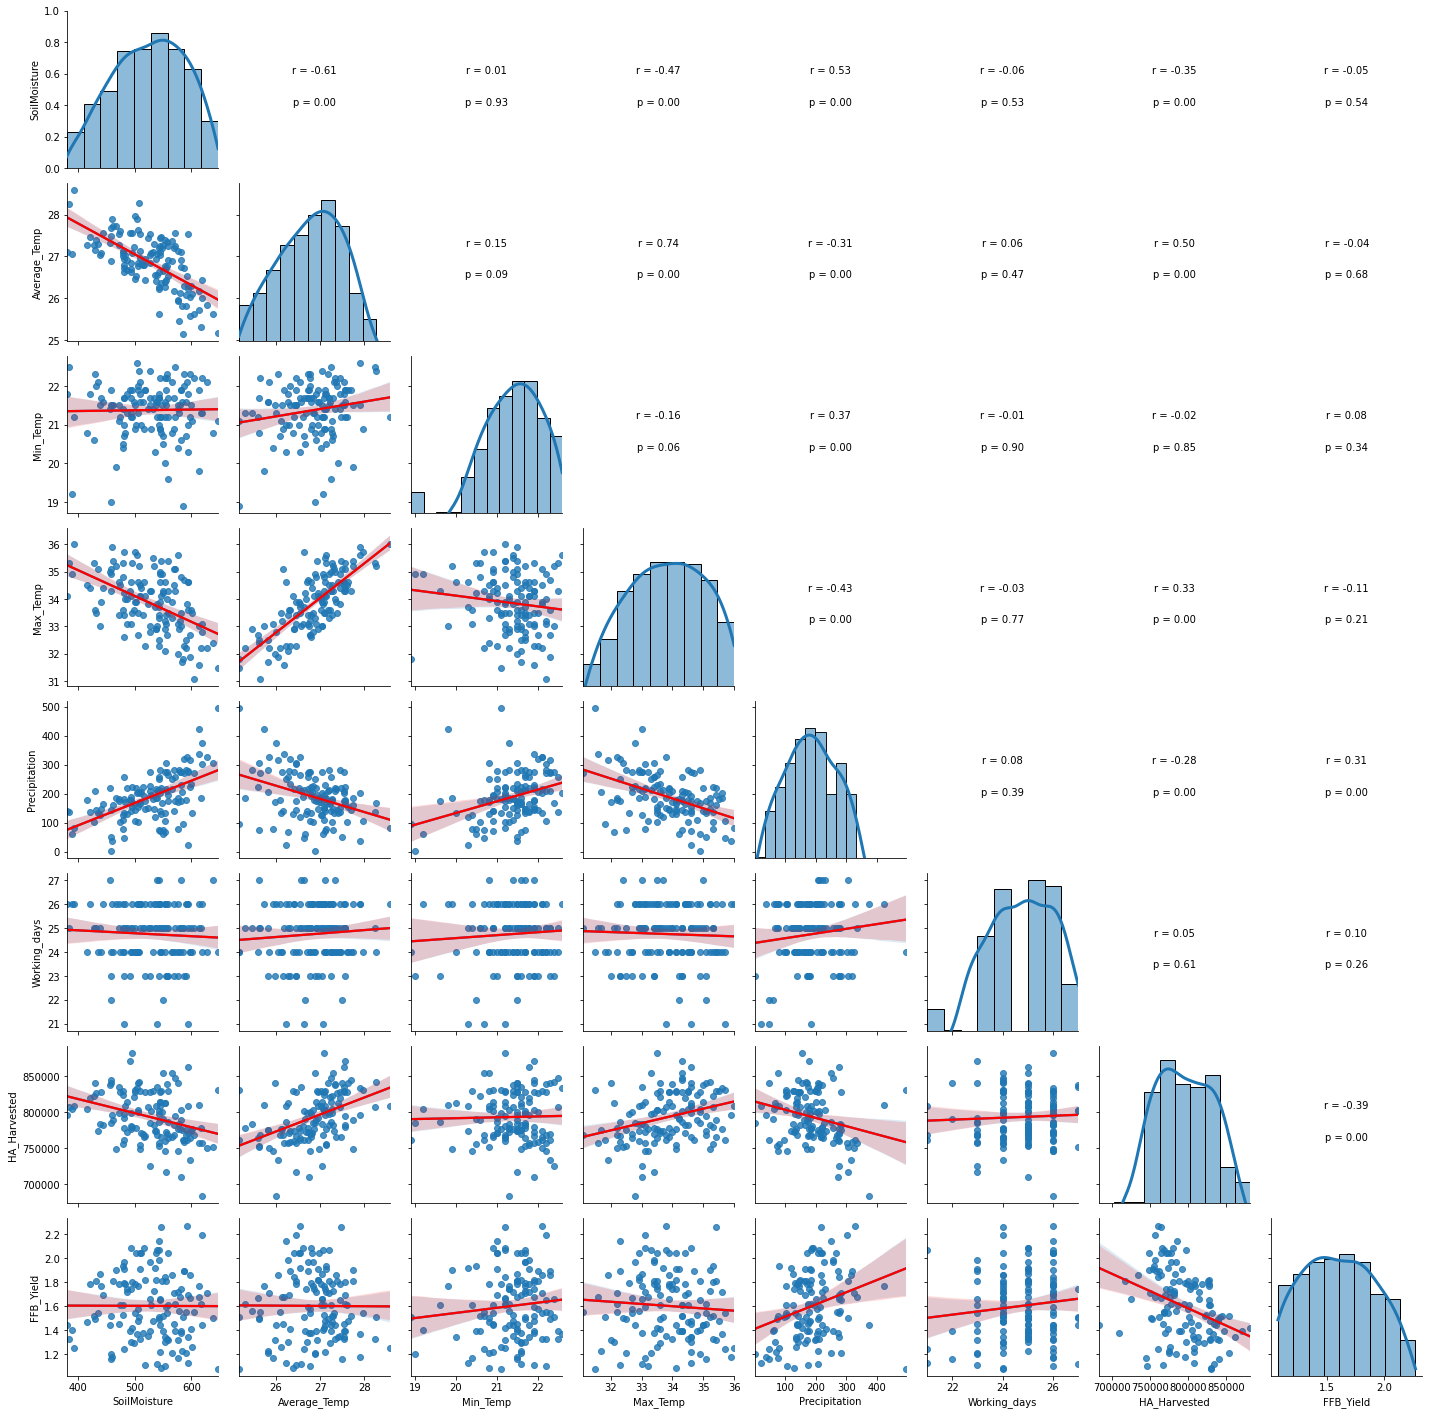

In [39]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

def reg_coef(x, y, label=None, color=None, **kwargs):
    ax = plt.gca()
    r, p = spearmanr(x, y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5, 0.6), xycoords='axes fraction', ha='center')
    ax.annotate('p = {:.2f}'.format(p), xy=(0.5, 0.4), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

pg = sns.PairGrid(dataset)
pg.map_diag(sns.histplot, kde=True, line_kws={'linewidth':3, 'color':'k'}, log_scale=(False,True))
pg.map_lower(sns.regplot)
pg.map_lower(sns.regplot, scatter=False,  fit_reg=True, color='r') 
pg.map_upper(reg_coef)
pg.savefig("distribution_and_spearman_correlation_coefficient_matrix.png") 